# Comparative Retrieval Evaluation
# This notebook compares Dense, Sparse, and Hybrid retrieval results from JSON evaluation files.

## Imports

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

In [23]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path("/home/al/Documents/rag-google-io")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

## Load Evaluation JSONs

In [41]:
import json
from pathlib import Path

# --------------------
# Helper function to get latest file by pattern
# --------------------
def get_latest_file(folder: Path, pattern: str) -> Path:
    files = list(folder.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files found matching {pattern} in {folder}")
    # Pick the file with the latest timestamp in filename
    # Assumes filenames have format like 'dense_eval_YYYYMMDDTHHMMSS.json'
    return max(files, key=lambda f: f.stem.split("_")[-1])

# --------------------
# Folders
# --------------------
eval_folder = Path("../data/eval/results")
ground_truth_folder = Path("../data/eval")

# --------------------
# Load latest evaluation files
# --------------------
dense_file = get_latest_file(eval_folder, "dense_eval_*.json")
sparse_file = get_latest_file(eval_folder, "sparse_eval_*.json")
hybrid_file = get_latest_file(eval_folder, "hybrid_eval_*.json")

with open(dense_file, "r") as f:
    dense_eval = json.load(f)
with open(sparse_file, "r") as f:
    sparse_eval = json.load(f)
with open(hybrid_file, "r") as f:
    hybrid_eval = json.load(f)

print(f"Loaded {len(dense_eval)} dense queries from {dense_file.name}")
print(f"Loaded {len(sparse_eval)} sparse queries from {sparse_file.name}")
print(f"Loaded {len(hybrid_eval)} hybrid queries from {hybrid_file.name}")

Loaded 15 dense queries from dense_eval_20260125T151933.json
Loaded 15 sparse queries from sparse_eval_20260125T151925.json
Loaded 15 hybrid queries from hybrid_eval_20260125T151944.json
Loaded 7 queries from latest ground truth file: ground_truth_manual.json


In [ ]:
# # --------------------
# # Load latest ground truth file
# # --------------------
# latest_gt_file = get_latest_file(ground_truth_folder, "ground_truth_*.json")
# with open(latest_gt_file, "r") as f:
#     ground_truth = json.load(f)

# print(f"Loaded {len(ground_truth)} queries from latest ground truth file: {latest_gt_file.name}")

In [57]:
from pathlib import Path
import json

# --------------------
# Load a specific ground truth file
# --------------------
gt_file = Path("../data/eval/ground_truth_gpt-5-nano_20260125T151027.json")  # <-- specify your file
with open(gt_file, "r") as f:
    ground_truth = json.load(f)

print(f"Loaded {len(ground_truth)} queries from ground truth file: {gt_file.name}")


Loaded 15 queries from ground truth file: ground_truth_gpt-5-nano_20260125T151027.json


## Create DataFrame for Comparison

In [42]:
def create_df(eval_list, method_name):
    return pd.DataFrame(eval_list).assign(method=method_name)

df_dense = create_df(dense_eval, "Dense")
df_sparse = create_df(sparse_eval, "Sparse")
df_hybrid = create_df(hybrid_eval, "Hybrid")

df_all = pd.concat([df_dense, df_sparse, df_hybrid], ignore_index=True)

# Optional: convert metrics to numeric if needed
metrics = ["recall_at_k", "mrr", "precision_at_k"]
for m in metrics:
    df_all[m] = pd.to_numeric(df_all[m])

## Compute Average Metrics

In [43]:
avg_metrics = df_all.groupby("method")[metrics].mean().reset_index()
print("Average Metrics per Retrieval Method:")
display(avg_metrics)

Average Metrics per Retrieval Method:


,method,recall_at_k,mrr,precision_at_k
0,Dense,0.400000,0.305556,0.080000
1,Hybrid,0.733333,0.633333,0.146667
2,Sparse,0.733333,0.583333,0.146667


## Visualization - Metrics Comparison

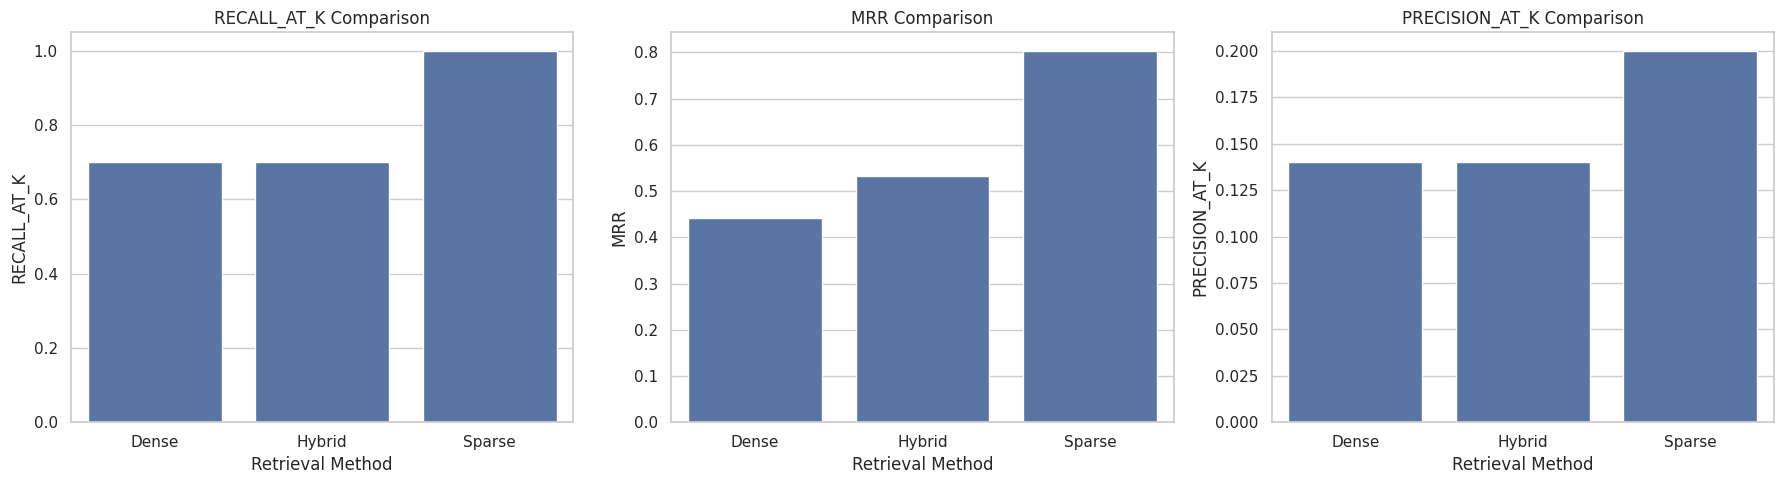

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for i, metric in enumerate(metrics):
    sns.barplot(data=avg_metrics, x="method", y=metric, ax=axes[i])
    axes[i].set_title(f"{metric.upper()} Comparison")
    axes[i].set_ylabel(metric.upper())
    axes[i].set_xlabel("Retrieval Method")

plt.tight_layout()
plt.show()

## Per-Query Comparison: Heatmap

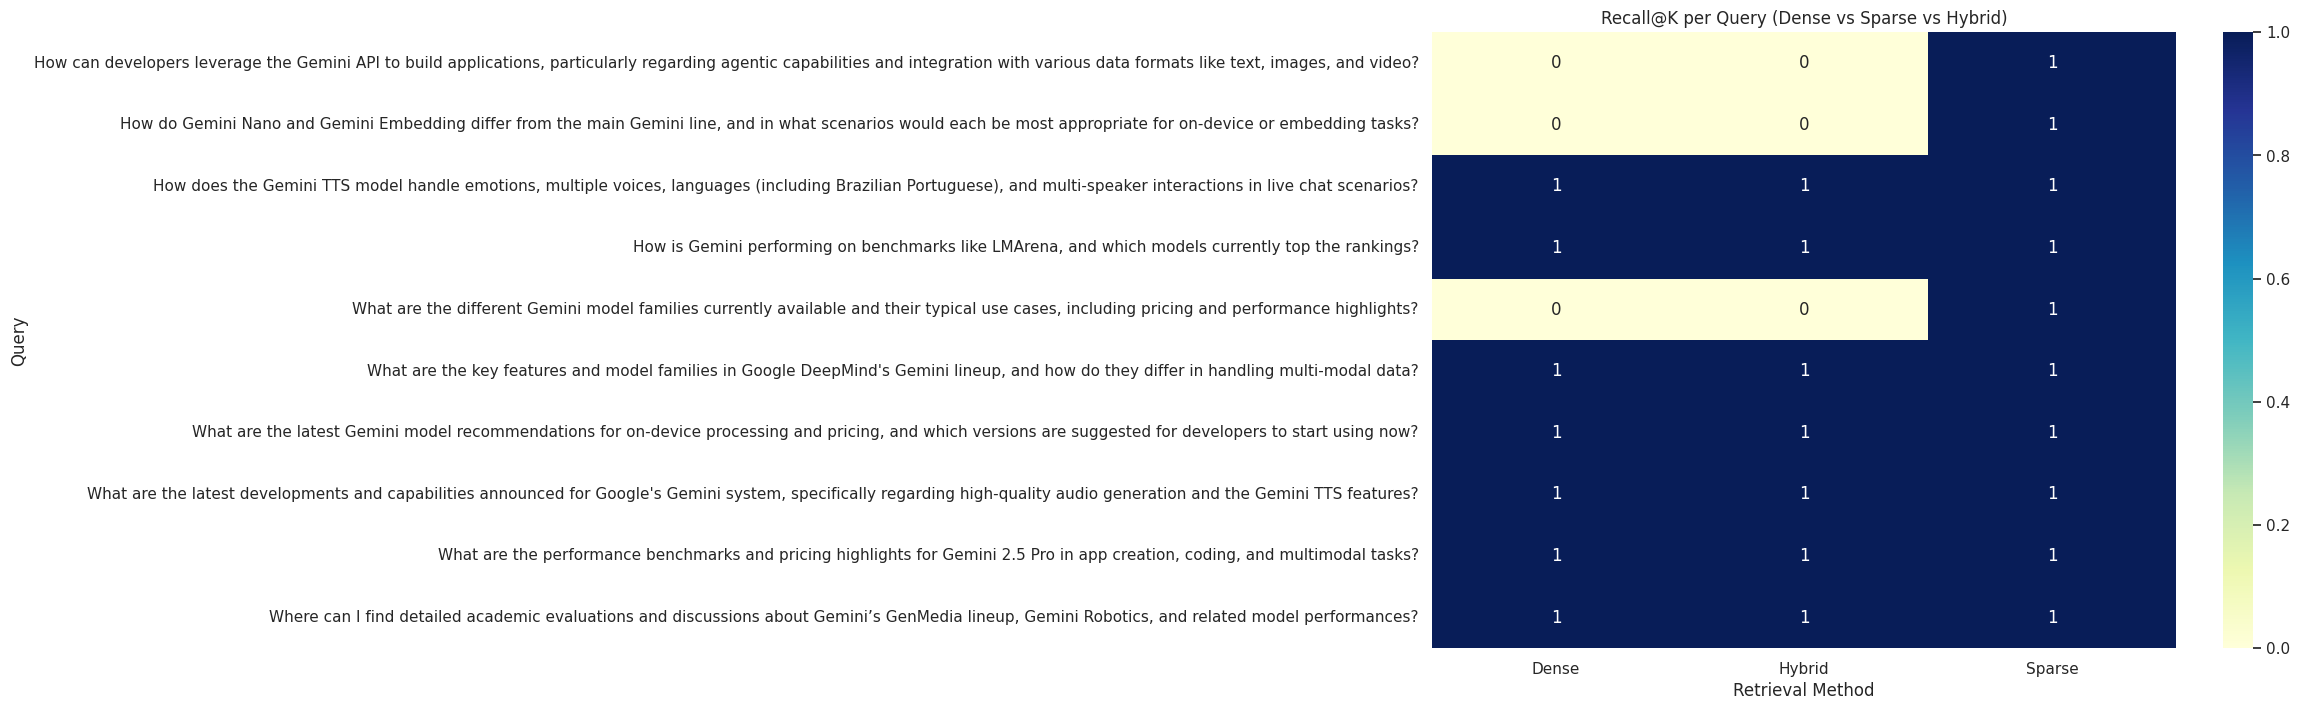

In [8]:
# Pivot table for Recall@K
pivot_recall = df_all.pivot(index="query", columns="method", values="recall_at_k")
plt.figure(figsize=(12,8))
sns.heatmap(pivot_recall, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Recall@K per Query (Dense vs Sparse vs Hybrid)")
plt.ylabel("Query")
plt.xlabel("Retrieval Method")
plt.show()

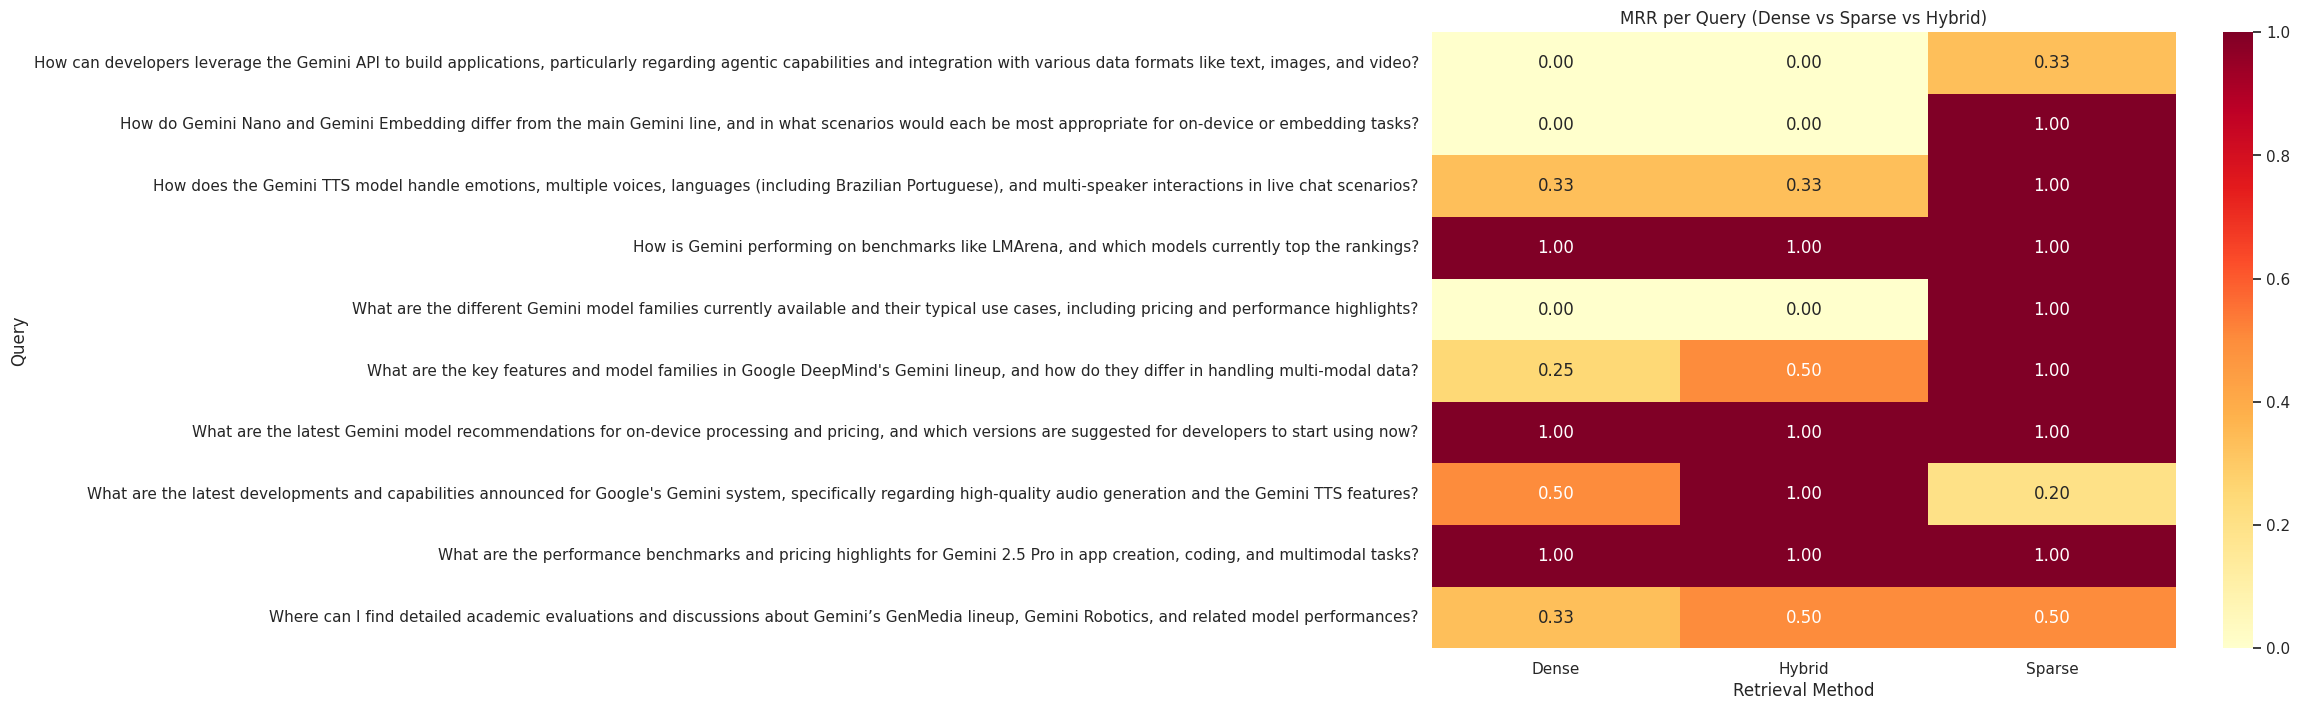

In [9]:
# MRR heatmap
pivot_mrr = df_all.pivot(index="query", columns="method", values="mrr")
plt.figure(figsize=(12,8))
sns.heatmap(pivot_mrr, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("MRR per Query (Dense vs Sparse vs Hybrid)")
plt.ylabel("Query")
plt.xlabel("Retrieval Method")
plt.show()

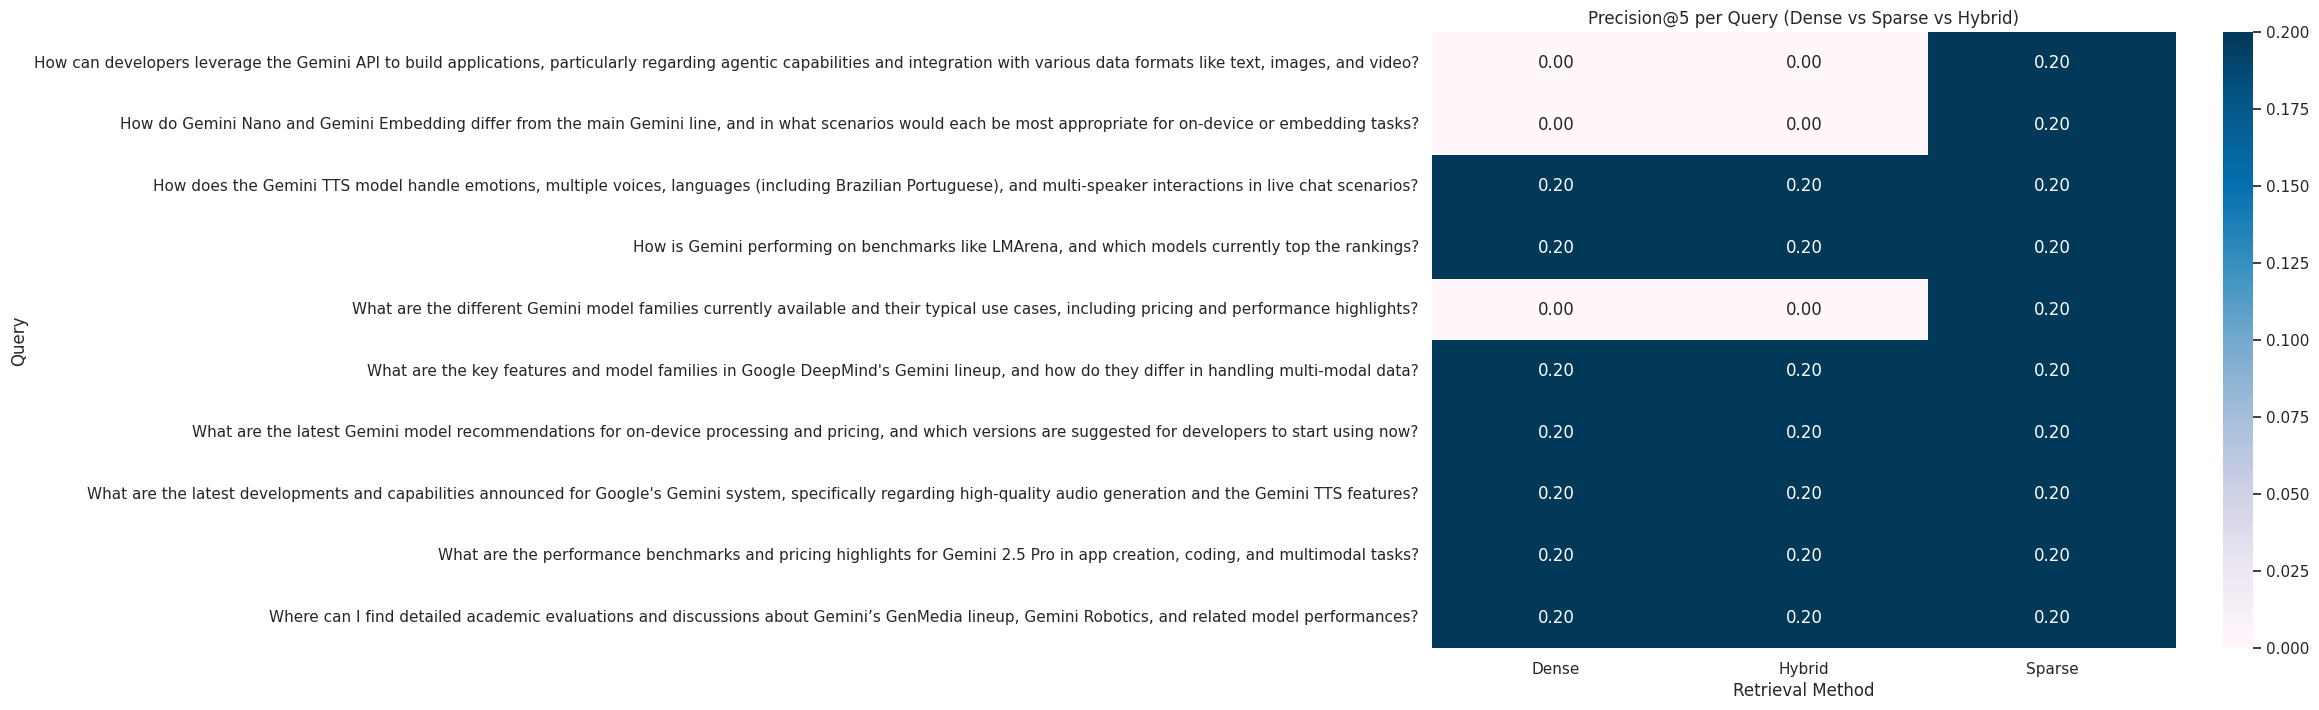

In [10]:
# Precision@5 heatmap
pivot_prec = df_all.pivot(index="query", columns="method", values="precision_at_k")
plt.figure(figsize=(12,8))
sns.heatmap(pivot_prec, annot=True, fmt=".2f", cmap="PuBu")
plt.title("Precision@5 per Query (Dense vs Sparse vs Hybrid)")
plt.ylabel("Query")
plt.xlabel("Retrieval Method")
plt.show()

## Difference Plots (Dense vs Sparse vs Hybrid)

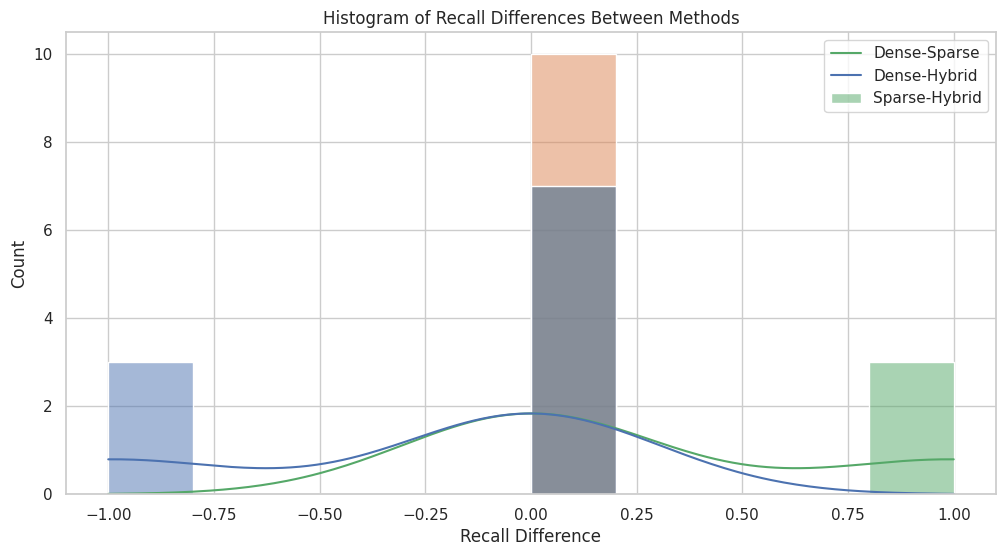

In [11]:
df_diff = df_all.pivot(index="query", columns="method", values="recall_at_k")
df_diff["Dense-Sparse"] = df_diff["Dense"] - df_diff["Sparse"]
df_diff["Dense-Hybrid"] = df_diff["Dense"] - df_diff["Hybrid"]
df_diff["Sparse-Hybrid"] = df_diff["Sparse"] - df_diff["Hybrid"]

plt.figure(figsize=(12,6))
sns.histplot(df_diff[["Dense-Sparse","Dense-Hybrid","Sparse-Hybrid"]], bins=10, kde=True)
plt.title("Histogram of Recall Differences Between Methods")
plt.xlabel("Recall Difference")
plt.ylabel("Count")
plt.legend(["Dense-Sparse","Dense-Hybrid","Sparse-Hybrid"])
plt.show()

In [25]:
# Plot scores by rank position
ranks = list(range(1, 6))  # Rank 1-5
avg_scores_by_rank = np.mean(all_scores, axis=0)

plt.figure(figsize=(8, 5))
plt.plot(ranks, avg_scores_by_rank, marker='o', linewidth=2, markersize=8)
plt.xlabel('Rank Position')
plt.ylabel('Average Cosine Similarity')
plt.title('Cosine Similarity by Rank (Dense Retrieval)')
plt.grid(True, alpha=0.3)
plt.xticks(ranks)
plt.show()

NameError: name 'all_scores' is not defined

## Optional: LLM Judge Analysis (if scores available)

In [12]:
 if "llm_score" in df_all.columns:
    avg_llm = df_all.groupby("method")["llm_score"].mean().reset_index()
    sns.barplot(data=avg_llm, x="method", y="llm_score")
    plt.title("Average LLM Judge Score per Retrieval Method")
    plt.show()

## Optional: Cosine Similarity Analysis (if cosine available)

In [13]:
if "avg_cosine" in df_all.columns:
    fig, ax = plt.subplots()
    sns.boxplot(data=df_all, x="method", y="avg_cosine", ax=ax)
    ax.set_title("Distribution of Average Cosine Similarity per Method")
    plt.show()

Combined evaluation saved as combined_eval_comparison.csv


## Save Combined Evaluation

In [ ]:
df_all.to_csv("../data/eval/combined_eval_comparison.csv", index=False)
print("Combined evaluation saved as combined_eval_comparison.csv")

# Debugging

In [19]:
# Verify hybrid collection has both dense and sparse vectors
from qdrant_client import QdrantClient
client = QdrantClient(url="http://localhost:6333")
collection_info = client.get_collection("/google-io-transcripts-hybrid")
print(collection_info)

status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> warnings=None indexed_vectors_count=99 points_count=99 segments_count=3 config=CollectionConfig(params=CollectionParams(vectors={'dense': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors={'bm25': SparseVectorParams(index=None, modifier=<Modifier.IDF: 'idf'>)}), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None, inline_storage=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=10000, flush_interval_sec=5, max_optimization_threads=

In [21]:
import json
from pathlib import Path

# Build the full path
gt_file = Path("/home/al/Documents/rag-google-io/data/eval/ground_truth_gpt5nano_20260122T203300.json")

# Or find it dynamically
gt_dir = Path("/home/al/Documents/rag-google-io/data/eval")
gt_files = sorted(gt_dir.glob("ground_truth_gpt5nano_*.json"), key=lambda p: p.stat().st_mtime, reverse=True)
gt_file = gt_files[0]  # Most recent

print(f"Loading: {gt_file}\n")

with open(gt_file) as f:
    gt = json.load(f)

print(f"Total queries: {len(gt)}\n")

# Show first 3 queries
for i, item in enumerate(gt[:3], 1):
    print(f"=== Query {i} ===")
    print(f"Query: {item['query']}")
    print(f"Relevant doc: {item['relevant_doc_ids']}")
    print()

Loading: /home/al/Documents/rag-google-io/data/eval/ground_truth_gpt5nano_20260122T203300.json

Total queries: 10

=== Query 1 ===
Query: How can developers leverage the Gemini API to build applications, particularly regarding agentic capabilities and integration with various data formats like text, images, and video?
Relevant doc: ['gHHjDRDNUNU__chunk_000']

=== Query 2 ===
Query: What are the key features and model families in Google DeepMind's Gemini lineup, and how do they differ in handling multi-modal data?
Relevant doc: ['gHHjDRDNUNU__chunk_000']

=== Query 3 ===
Query: How do Gemini Nano and Gemini Embedding differ from the main Gemini line, and in what scenarios would each be most appropriate for on-device or embedding tasks?
Relevant doc: ['gHHjDRDNUNU__chunk_001']



In [24]:
from retrieval.retrievers.retrieve_dense import retrieve_dense
from retrieval.retrievers.retrieve_hybrid import retrieve_hybrid

# Pick the first query
query = gt[0]["query"]
relevant_id = gt[0]["relevant_doc_ids"][0]

print(f"Testing query: {query}")
print(f"Expected doc: {relevant_id}\n")

# Test dense
print("=== DENSE RESULTS ===")
dense_results = retrieve_dense(query, top_k=5)
for i, point in enumerate(dense_results, 1):
    doc_id = point.payload.get("doc_id")
    match = "✅" if doc_id == relevant_id else "  "
    print(f"{match} {i}. {doc_id[:30]}... (score: {point.score:.4f})")

# Test hybrid
print("\n=== HYBRID RESULTS ===")
hybrid_results = retrieve_hybrid(query, top_k=5)
for i, point in enumerate(hybrid_results, 1):
    doc_id = point.payload.get("doc_id")
    match = "✅" if doc_id == relevant_id else "  "
    print(f"{match} {i}. {doc_id[:30]}... (score: {point.score:.4f})")

# Check if results are identical
dense_ids = [p.payload.get("doc_id") for p in dense_results]
hybrid_ids = [p.payload.get("doc_id") for p in hybrid_results]
print(f"\nAre results identical? {dense_ids == hybrid_ids}")

[INFO] Dense retriever initialized
[INFO] Collection: google-io-transcripts-dense
[INFO] Embedding model: sentence-transformers/all-MiniLM-L6-v2
[INFO] Embedding dim: 384
[INFO] Hybrid retriever initialized
[INFO] Collection: google-io-transcripts-hybrid
[INFO] Embedding model: sentence-transformers/all-MiniLM-L6-v2
[INFO] Embedding dim: 384
Testing query: How can developers leverage the Gemini API to build applications, particularly regarding agentic capabilities and integration with various data formats like text, images, and video?
Expected doc: gHHjDRDNUNU__chunk_000

=== DENSE RESULTS ===
   1. gHHjDRDNUNU__chunk_017... (score: 0.6132)
   2. gHHjDRDNUNU__chunk_007... (score: 0.6127)
   3. 4TE-KFXvhAk__chunk_002... (score: 0.5668)
   4. gHHjDRDNUNU__chunk_009... (score: 0.5666)
   5. gHHjDRDNUNU__chunk_008... (score: 0.5654)

=== HYBRID RESULTS ===
   1. gHHjDRDNUNU__chunk_017... (score: 0.6132)
   2. gHHjDRDNUNU__chunk_007... (score: 0.6127)
   3. 4TE-KFXvhAk__chunk_002... (score:

In [33]:
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")

# Check all collections
collections = client.get_collections()
print("Available collections:")
for c in collections.collections:
    print(f"  - {c.name}")

# Check hybrid collection specifically
try:
    hybrid_info = client.get_collection("google-io-transcripts-hybrid")
    print(f"\nHybrid collection:")
    print(f"  Points: {hybrid_info.points_count}")
    print(f"  Vectors config: {hybrid_info.config.params.vectors}")
    print(f"  Sparse vectors config: {hybrid_info.config.params.sparse_vectors}")
except Exception as e:
    print(f"❌ Hybrid collection error: {e}")

Available collections:
  - google-io-transcripts-dense
  - google-io-transcripts-hybrid
  - google-io-transcripts-sparse
  - hybrid_collection
  - sparse_collection
  - google-io-transcripts

Hybrid collection:
  Points: 99
  Vectors config: {'dense': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}
  Sparse vectors config: {'bm25': SparseVectorParams(index=None, modifier=<Modifier.IDF: 'idf'>)}


In [35]:
from retrieval.retrievers.retrieve_dense import retrieve_dense
from retrieval.retrievers.retrieve_hybrid import retrieve_hybrid
#from retrieval.retrievers.retrieve_sparse import retrieve_sparse  # if you have this

query = gt[0]["query"]
relevant_id = gt[0]["relevant_doc_ids"][0]

print(f"Query: {query}")
print(f"Expected: {relevant_id}\n")

# Test each method
for method_name, method in [("Dense", retrieve_dense), ("Hybrid", retrieve_hybrid)]:
    results = method(query, top_k=5)
    print(f"\n{method_name} results:")
    for i, point in enumerate(results, 1):
        doc_id = point.payload.get("doc_id", str(point.id))
        match = "✓" if doc_id == relevant_id else " "
        print(f"  {match} {i}. {doc_id} (score: {point.score:.4f})")
        print(f"      {point.payload.get('text', '')[:100]}...")

Query: How can developers leverage the Gemini API to build applications, particularly regarding agentic capabilities and integration with various data formats like text, images, and video?
Expected: gHHjDRDNUNU__chunk_000


Dense results:
    1. gHHjDRDNUNU__chunk_017 (score: 0.6132)
      If you're building
a research agent, maybe you want to
use the Chat API. If you're building
a gaming...
    2. gHHjDRDNUNU__chunk_007 (score: 0.6127)
      We launched a Java during
I/O, right, Shrestha? And also, you have
the ability to use the API on oth...
    3. 4TE-KFXvhAk__chunk_002 (score: 0.5668)
      it's really good at coding
and also more complex prompts. It leads coding
benchmarks including WebDe...
    4. gHHjDRDNUNU__chunk_009 (score: 0.5666)
      But Luciano and I thought we
would hit some of the highlights that we really want people
to know mor...
    5. gHHjDRDNUNU__chunk_008 (score: 0.5654)
      And then, of course, you can
take all that information. And if you want to create
bea

In [36]:
# Get a sample point from each collection
# this is just confirming the data is properly formatted
dense_sample = client.scroll(
    collection_name="google-io-transcripts-dense",
    limit=1,
    with_payload=True
)[0][0]

print(f"Dense collection doc_id format: {dense_sample.payload.get('doc_id')}")
print(f"Ground truth doc_id format: {gt[0]['relevant_doc_ids'][0]}")
print(f"Match: {dense_sample.payload.get('doc_id') == gt[0]['relevant_doc_ids'][0]}")

Dense collection doc_id format: 4TE-KFXvhAk__chunk_005
Ground truth doc_id format: gHHjDRDNUNU__chunk_000
Match: False


### Checking for Data Leakage in ground truth

In [38]:
import json

with open("../data/eval/ground_truth_gpt-5-nano_20260125T145528.json") as f:
    gt = json.load(f)

# Print some questions
for i, item in enumerate(gt[:5], 1):
    print(f"\n{i}. Query: {item['query'][:100]}...")
    print(f"   Doc: {item['relevant_doc_ids'][0]}")


1. Query: How does the Gemini API enable building multi-modal applications, and what are the key agentic featu...
   Doc: gHHjDRDNUNU__chunk_000

2. Query: What are the different families of Gemini models and how do they differ in terms of capabilities and...
   Doc: gHHjDRDNUNU__chunk_000

3. Query: What Gemini model options are currently available, and what are their key use cases and performance ...
   Doc: gHHjDRDNUNU__chunk_001

4. Query: Which Gemini variants are optimized for mobile or embedding tasks, and how do their capabilities com...
   Doc: gHHjDRDNUNU__chunk_001

5. Query: How has the Gemini platform's performance been evaluated in benchmarks like LMArena, and what do use...
   Doc: gHHjDRDNUNU__chunk_002


## Potential Causes of High Sparse Performance:

### Most Probable - GPT 5 Nano is not the best fit for purpose

### Query-Document Overlap

In [58]:
# Measure keyword overlap
def keyword_overlap(query, doc_text):
    query_words = set(query.lower().split())
    doc_words = set(doc_text.lower().split())
    overlap = query_words & doc_words
    return len(overlap) / len(query_words) if query_words else 0

overlaps = []
for gt_item in ground_truth:
    query = gt_item["query"]
    doc_id = gt_item["relevant_doc_ids"][0]
    
    # Find the document
    doc = next(d for d in docs if d["id"] == doc_id)
    
    overlap_pct = keyword_overlap(query, doc["text"])
    overlaps.append(overlap_pct)
    
    if overlap_pct > 0.5:  # Flag high overlap
        print(f"⚠️  {overlap_pct:.1%} overlap: {query[:60]}...")

print(f"\nAverage keyword overlap: {np.mean(overlaps):.1%}")

⚠️  57.1% overlap: how to integrate Gemini API for building AI apps with text, ...
⚠️  71.4% overlap: what is Gemini model family and how do I use it for multi-mo...
⚠️  70.0% overlap: how do Gemini embeddings work for semantic search and rankin...
⚠️  81.8% overlap: how to run Gemini Nano on Android devices for on-device inte...
⚠️  81.8% overlap: what are the different Gemini AI models and what are they be...
⚠️  80.0% overlap: how does the Gemini 2.5 series compare to older versions...
⚠️  72.7% overlap: what are the best Gemini models right now for on-device task...
⚠️  69.2% overlap: where can I test AI models with LMArena and see their Elo ra...
⚠️  70.0% overlap: how do Gemini models perform on coding and multimodal tasks...
⚠️  66.7% overlap: what is Gemini 2.5 Pro and what can it do for app building...
⚠️  60.0% overlap: where can I learn about Gemini GenMedia and robotic models...
⚠️  72.7% overlap: how can I generate natural-sounding speech from text with Ge...
⚠️  66.7% ove

Expected values:

✅ < 30% overlap: Natural, diverse questions
⚠️ 30-50% overlap: Somewhat keyword-specific
❌ > 50% overlap: Data leakage, questions too close to source

### Chunk size too small

In [44]:
import json
import numpy as np

with open("../data/canonical/all_documents.json") as f:
    docs = json.load(f)

# Analyze chunk sizes
chunk_lengths = [len(doc["text"].split()) for doc in docs]

print(f"Total chunks: {len(docs)}")
print(f"Avg words per chunk: {np.mean(chunk_lengths):.0f}")
print(f"Min words: {min(chunk_lengths)}")
print(f"Max words: {max(chunk_lengths)}")
print(f"Std dev: {np.std(chunk_lengths):.0f}")

# Check if chunks are too similar
print(f"\nSample chunk IDs:")
for doc in docs[:5]:
    print(f"  {doc['id']}: {len(doc['text'].split())} words")

Total chunks: 99
Avg words per chunk: 353
Min words: 62
Max words: 393
Std dev: 44

Sample chunk IDs:
  gHHjDRDNUNU__chunk_000: 363 words
  gHHjDRDNUNU__chunk_001: 361 words
  gHHjDRDNUNU__chunk_002: 363 words
  gHHjDRDNUNU__chunk_003: 372 words
  gHHjDRDNUNU__chunk_004: 345 words


Red flags:

❌ Chunks < 100 words: Too small, keywords too concentrated
❌ All chunks from same video: Less diversity
❌ Low std dev: Chunks too uniform

### Limited Vocabulary (Small Dataset)

In [45]:
# Check vocabulary diversity
all_text = " ".join(doc["text"] for doc in docs)
unique_words = set(all_text.lower().split())

print(f"Total words: {len(all_text.split())}")
print(f"Unique words: {len(unique_words)}")
print(f"Vocabulary richness: {len(unique_words) / len(all_text.split()):.3f}")

Total words: 34934
Unique words: 4660
Vocabulary richness: 0.133


What to expect:

Small dataset → Limited vocabulary → Easier for BM25 to match keywords
At scale (99 chunks), vocabulary grows → BM25 performance drops

### Technical Jargon Repetition

In [46]:
# Check for repeated technical terms
from collections import Counter

words = all_text.lower().split()
word_freq = Counter(words)

print("\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    if len(word) > 3:  # Skip short words
        print(f"  {word}: {count}")


Top 20 most common words:
  that: 550
  this: 320
  with: 307
  have: 280


Red flags:

Same technical terms appear 50+ times
Limited synonym usage

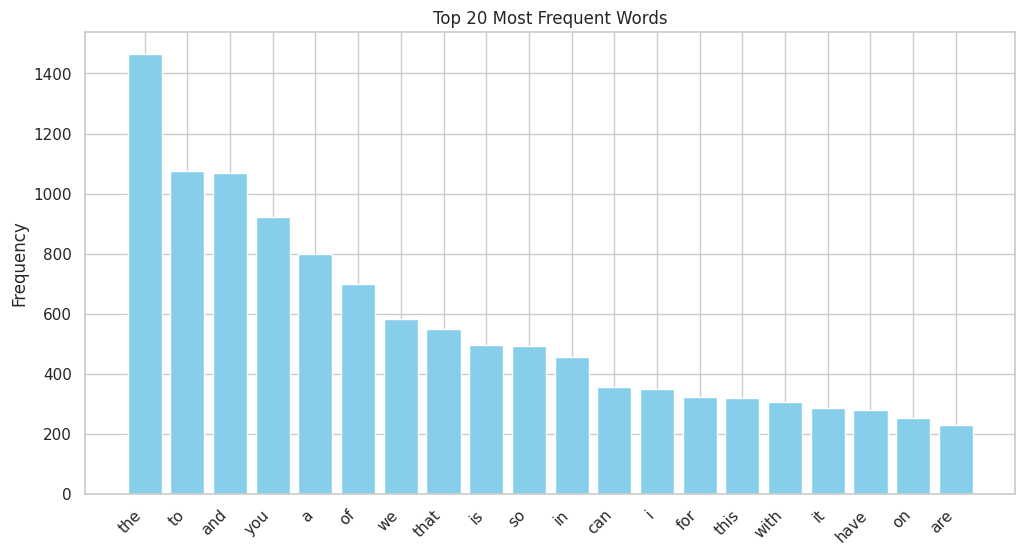

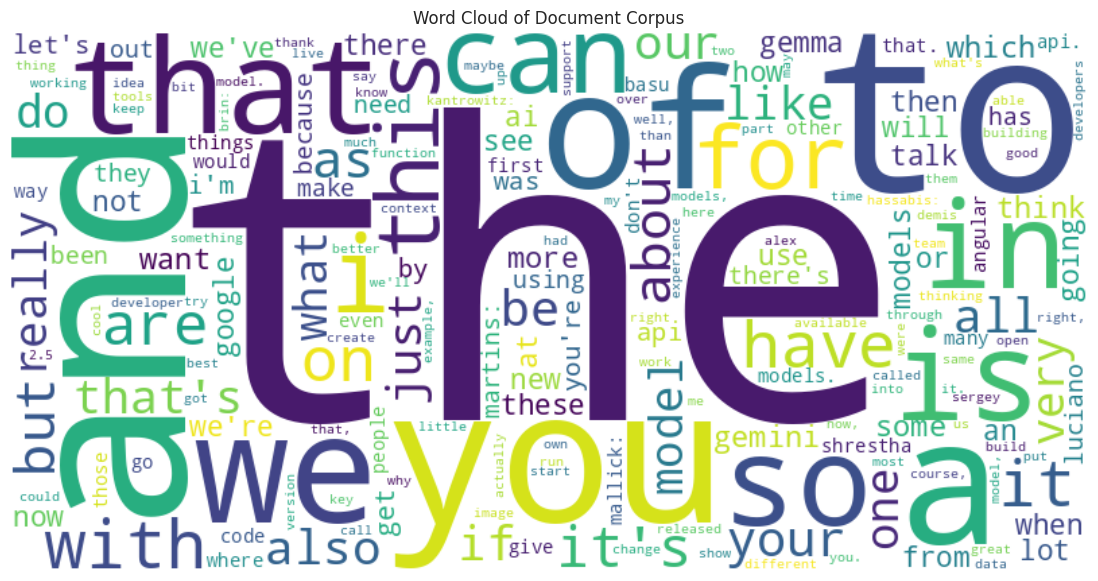

In [50]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import json

# Assuming 'docs' is your list of documents
all_text = " ".join(doc["text"] for doc in docs)
words = all_text.lower().split()

# Count word frequencies
word_counts = Counter(words)

# ----------------------------
# Top 20 words bar chart
# ----------------------------
top_n = 20
top_words = word_counts.most_common(top_n)
words_labels, counts = zip(*top_words)

plt.figure(figsize=(12,6))
plt.bar(words_labels, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {top_n} Most Frequent Words")
plt.ylabel("Frequency")
plt.show()

# ----------------------------
# Word Cloud
# ----------------------------
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Document Corpus")
plt.show()


### BM25 Parameter Tuning

In [47]:
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")
sparse_info = client.get_collection("google-io-transcripts-sparse")

print("Sparse vector config:")
print(sparse_info.config.params.sparse_vectors)

Sparse vector config:
{'bm25': SparseVectorParams(index=None, modifier=<Modifier.IDF: 'idf'>)}


Look for the IDF modifier - if it's too aggressive, rare keywords get over-weighted.